# Körperschwerpunkt
Wir haben zuvor Punkte (2D) in Skillspector annotiert und digitalisiert und wollen von diesen nun den Verlauf des Körperschwerpunkt berechnen. Dazu benutzen wir das Modell nach Dempster: der Körper wird in Segmente (zB Oberarm, Schenkel, ...) unterteilt. Für jedes segment ist ein Schwerpunkt, sowie das relative Gewicht angegeben. Hieraus kann der Schwerpunkte mit den untenstehenden Formeln berechnet werden. 

__Eingabe__: <br>
1. digitalisierte Daten ("pos_vel_acc_smoothed_xy.txt")
2. csv tabelle mit den paramter nach dempster ("dempster_parameters.csv")
         
__Ausgabe__: <br>
- array mit körperschwerpunkt für alle jeden frame.


#### Schritte:

1. lese daten
2. stelle daten dar und verifiziere korrektheit
3. berechne die xy-koordinaten der schwerpunkte aller segmente
4. berechne die xy-koordinate des körperschwerpunktes als gewichtete summe
5. schöne plots

<img src="hanavan_cuts.png" alt="Drawing" style="width: 300px;"/>
<img src="dempster_table.png" alt="Drawing" style="width: 500px;"/>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from PIL import Image
from pandas import DataFrame
from collections import defaultdict

In [2]:
# export output from skillspector and load into dataframe
df_data = pd.read_csv('pos_vel_acc_smoothed_xy.txt', sep='\t')
display(df_data.head(5))

# load the dempster parameters
df_dempster = pd.read_csv('dempster_parameters.csv')

,Toe - X pos,Toe - Y pos,Toe - X vel,Toe - Y vel,Toe - X acl,Toe - Y acl,Ankle - X pos,Ankle - Y pos,Ankle - X vel,Ankle - Y vel,...,Forhead - Y vel,Forhead - X acl,Forhead - Y acl,CG - X pos,CG - Y pos,CG - X vel,CG - Y vel,CG - X acl,CG - Y acl,Unnamed: 114
0,1.667,0.285,5.378,-1.814,-147.358,106.223,1.505,0.192,4.292,1.352,...,0.874,6.958,-31.753,0.819,0.974,4.762,0.049,20.120,-36.824,NaN
1,1.759,0.246,8.486,-4.055,-151.365,-28.492,1.581,0.187,7.062,-2.079,...,1.297,5.376,-30.075,0.915,0.972,9.770,-0.393,16.381,-32.732,NaN
2,1.836,0.204,6.953,-5.014,-155.371,-163.208,1.647,0.150,6.041,-4.399,...,1.005,3.794,-28.398,1.014,0.966,9.916,-0.700,12.642,-28.641,NaN
3,1.898,0.145,5.368,-6.311,-161.499,-96.157,1.702,0.099,5.087,-4.683,...,0.741,0.266,-24.439,1.114,0.958,10.000,-0.904,4.348,-12.277,NaN
4,1.944,0.078,3.749,-6.117,-162.307,134.954,1.748,0.057,4.261,-3.008,...,0.530,-5.289,-17.722,1.214,0.948,9.979,-0.876,-8.581,17.895,NaN


In [3]:
# check that all the segments in the dempster sum to 1
assert(sum(df_dempster['seg_weight'] * df_dempster['sides']) == 1)

# translate the points from skillspector to dempster table names.
# REMARK: skillspector names the LEFT element with ".1" (e.g. right: "Toe - X pos" and left: "Toe - X pos.1")

# get all the marker names:
#np.unique(df_dempster[['proximal', 'distal']])

markers = ['ankle', 'elbow', 'finger', 'forhead', 'hip', 'knee', 'sholder', 'toe', 'wrist']

# this marker doesn't exit in the skillspector, so we instead use the middle point between the shoulders.
special_markers = ['neck']

# quick helper function, to simplify mapping from the marker names to skillspector names. 
def make_name(base, xy, right):
    lr = '' if right else '.1'
    return  '%s - %s pos%s'%(base.capitalize(), xy, lr)

# extract all necessary points from dataframe
names = []
for m in markers:
    for lr in [True, False]:
        for xy in ['X','Y']:
            name = make_name(m, xy, lr)
            if name in df_data:
                names.append(name)
print names

# and convert the data into a concise table for display
data_array = np.array(df_data[names])
N, d = data_array.shape

i = 0
# for each frame, we have X and Y coordinates for each joint in subsequent order.
# we can now fold the tensor into a 3rd dimension to get a datastructure with indices:
# (frame, joint, xy-coordinate)
points = data_array.reshape(N, d/2, 2)
print 'points.shape = ', points.shape

['Ankle - X pos', 'Ankle - Y pos', 'Ankle - X pos.1', 'Ankle - Y pos.1', 'Elbow - X pos', 'Elbow - Y pos', 'Elbow - X pos.1', 'Elbow - Y pos.1', 'Finger - X pos', 'Finger - Y pos', 'Finger - X pos.1', 'Finger - Y pos.1', 'Forhead - X pos', 'Forhead - Y pos', 'Hip - X pos', 'Hip - Y pos', 'Hip - X pos.1', 'Hip - Y pos.1', 'Knee - X pos', 'Knee - Y pos', 'Knee - X pos.1', 'Knee - Y pos.1', 'Sholder - X pos', 'Sholder - Y pos', 'Sholder - X pos.1', 'Sholder - Y pos.1', 'Toe - X pos', 'Toe - Y pos', 'Toe - X pos.1', 'Toe - Y pos.1', 'Wrist - X pos', 'Wrist - Y pos', 'Wrist - X pos.1', 'Wrist - Y pos.1']
points.shape =  (25, 17, 2)


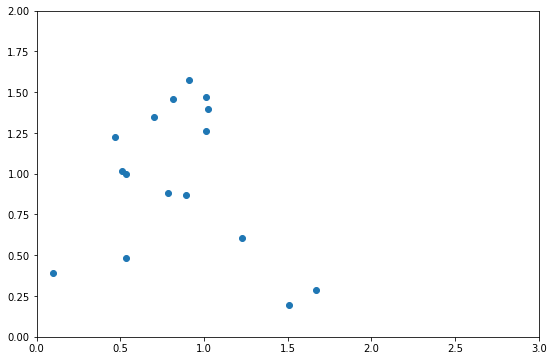

In [4]:
# display the movement of the joints through time.
# animate by clicking ctrl+enter multiple times.
plt.figure(figsize=(9, 6))
plt.scatter(*points[i].T)
plt.xlim(0,3)
plt.ylim(0,2)
i+=1

## berechne segmente und schwerpunkt

hier der entsprechende text aus "research methods in biomechanics" (robertson)

<img src="dempster_explain1.png" alt="Drawing" style="width: 300px;"/>
<img src="dempster_explain2.png" alt="Drawing" style="width: 300px;"/>
<img src="dempster_explain3.png" alt="Drawing" style="width: 300px;"/>

In [5]:
# now actually compute the segments.
display(df_dempster)

,name,proximal,distal,cm_ratio_clauser,cm_ratio,seg_weight,seg_weight_clauser,sides
0,hand,wrist,finger,0.1800,0.506,0.0060,0.0065,2
1,forearm,elbow,wrist,0.3896,0.430,0.0160,0.0161,2
2,upper_arm,sholder,elbow,0.5130,0.436,0.0280,0.0263,2
3,foot,ankle,toe,0.4485,0.500,0.0145,0.0147,2
4,leg,knee,ankle,0.3705,0.433,0.0465,0.0435,2
5,thigh,hip,knee,0.3719,0.433,0.1000,0.1027,2
6,trunk,neck,hip,0.3803,0.495,0.4970,0.5070,1
7,head,neck,forhead,0.4642,1.000,0.0810,0.0728,1


In [6]:
# empty array for the center of mass of each frame
centers = []

# for every segment rule in the dempster table
for _, row in df_dempster.iterrows():
    # we compute formulas 3.11 and 3.12 in this variable.
    center_of_mass = 0
    for lr in [True, False] if row['sides'] == 2 else [True]:
        # what does this row say?
        print '*%s* goes from *%s* to *%s*'%(row['name'], row['proximal'], row['distal'])
        
        # the neck was not digatized, so we need to build a little workaround
        if row['proximal']=='neck':
            # we have that pesty neck. use the midpoint between shoulders.
            prox = (np.array(df_data[[make_name('sholder', xy, True) for xy in 'XY']]) + 
                    np.array(df_data[[make_name('sholder', xy, False) for xy in 'XY']])) / 2.
        else:
            # otherwise the source (proximal end) of the segment the X and Y 
            # coordinates of the respective joint. prox is a [N, 2] sized matrix. where N
            # is the number of frames and 2 for X and Y.
            prox = np.array(df_data[[make_name(row['proximal'], xy, lr) for xy in 'XY']])
        dist = np.array(df_data[[make_name(row['distal'], xy, lr) for xy in 'XY']])
        
        # compute formulas 3.6 and 3.7
        seg_center = prox + row['cm_ratio'] * (dist - prox)
        
        # add it weighted to the overall center. (3.11, 3.12)
        center_of_mass += seg_center * row['seg_weight']
    centers.append(center_of_mass)

# centers now contains an array of 8 partial sums, with dimension [25, 2] each.
# 8 because we have 8 rules in the dempster table. 25 is the number of frames and 2 
# for x and y.
# to combine all these, take the sum over the 0th dimension.
center_array = np.sum(np.array(centers), 0)

*hand* goes from *wrist* to *finger*
*hand* goes from *wrist* to *finger*
*forearm* goes from *elbow* to *wrist*
*forearm* goes from *elbow* to *wrist*
*upper_arm* goes from *sholder* to *elbow*
*upper_arm* goes from *sholder* to *elbow*
*foot* goes from *ankle* to *toe*
*foot* goes from *ankle* to *toe*
*leg* goes from *knee* to *ankle*
*leg* goes from *knee* to *ankle*
*thigh* goes from *hip* to *knee*
*thigh* goes from *hip* to *knee*
*trunk* goes from *neck* to *hip*
*head* goes from *neck* to *forhead*


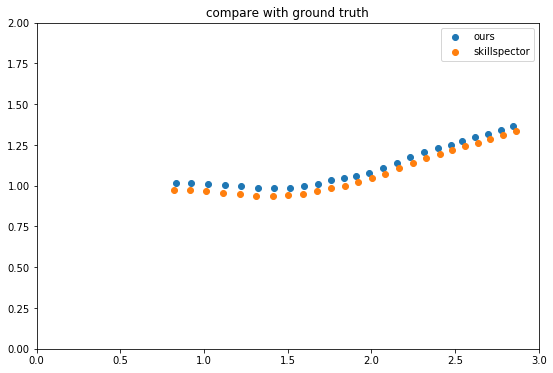

In [7]:
# display the whole mess in comparison to the center of gravity computed by skillspector.
plt.figure(figsize=(9, 6))
plt.scatter(*center_array.T, label='ours')
plt.scatter(df_data['CG - X pos'], df_data['CG - Y pos'], label='skillspector')
plt.xlim(0,3)
plt.ylim(0,2)
plt.title('compare with ground truth')
plt.legend()
None